# Project name - Regression

## Problem definition
> Insert here your problem description

## Data
Explain the dataset, how all files are composed and the description of each column

## Evaluation
Explain the evaluation metric that you want to use to evaluate the model. Specify the goal in terms of evaluation metric

### What will be covered
1. Import of common libraries
2. Data ingestion & cleaning
3. Data Analysis and visualization
4. Feature Selection
5. ML model selection
6. ML model tuning
7. Results visualizations
8. Model export
9. Python and html generation

#### Assumptions
* Data is provided with a single csv file with an header representing the columns'names

### Parameters

In [135]:
INPUT_DATA_FILE = 'data/example'
INSTALL_LIBRARIES = False
REMOVE_ROWS_WITH_INVALID_COLS = True #if False then a SimpleImputer will be used
MATPLOT_STYLE = 'seaborn-dark-palette'
TARGET_COLUMN = 'target'
#if different from None it represents the number of wanted features in the feature selection step
NUM_FEATURES = 5
MODEL_EXP_PATH = 'bestRegressor.joblib'
OUTPUT_SCRIPT_NAME = 'modelPython.py'
OUTPUT_HTML_NAME = 'model_report.html'
MODEL_EXPORT = True
REPORT_GEN = True
DATA_VISUALIZATION_STEP = True
RESULT_VISUALIZATION_STEP = True


columns_to_remove =['5']

#Scoring for tuning step
#https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
scoring_tuning = 'neg_mean_absolute_error'

#custom_loss must be None or one of the sklearn.metrics
from sklearn.metrics import mean_absolute_error
custom_loss = mean_absolute_error

#not include the target in this list
column_to_visualize = ['1','8','10','67']

column_names_and_types= {
         '0': 'float64',
         '1': 'float64',
         '2': 'float64',
         TARGET_COLUMN : 'float64'
        }

#this manage eventually data errors in the dataset using coerce
numeric_features = ['0','1']
datetime_features = []


from sklearn import linear_model
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor

#this will be used in step 5
regressors = [
    linear_model.SGDRegressor(max_iter=1000, tol=1e-3),
    linear_model.Lasso(alpha=0.1),
    linear_model.Ridge(alpha=1.0),
    BaggingRegressor(base_estimator=SVR(),n_estimators=10, random_state=0),
    AdaBoostRegressor(random_state=0, n_estimators=100),
    SVR(C=1.0, epsilon=0.2)
]

### 1-Import of common libraries

In [136]:
if INSTALL_LIBRARIES:
    import sys
    !conda install --yes --prefix {sys.prefix} matplotlib
    !conda install --yes --prefix {sys.prefix} numpy
    !conda install --yes --prefix {sys.prefix} pandas
    !conda install --yes --prefix {sys.prefix} scikit-learn
    !conda install --yes --prefix {sys.prefix} ipython
    !conda install --yes --prefix {sys.prefix} seaborn

import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
from sklearn import metrics
from IPython.display import display
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import json
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import pprint
import heapq
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


%matplotlib inline



plt.style.use(MATPLOT_STYLE)
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (26, 20),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)

### 2-Data ingestion & cleaning

In [137]:
#raw_input_df = pd.read_csv(INPUT_DATA_FILE, infer_datetime_format=True, index_col=False, skipinitialspace=True)

from sklearn.datasets import make_regression

X,y = make_regression()
raw_input_df = pd.DataFrame(X)
raw_input_df[TARGET_COLUMN] = pd.Series(y)
raw_input_df.columns = raw_input_df.columns.astype(str)
raw_input_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,target
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.096897,0.001941,0.133466,-0.000911,-0.068790,-0.005472,0.074951,0.017771,0.016984,0.038484,...,-0.139041,-0.040017,0.030783,0.109005,-0.036551,-0.020314,-0.103327,0.079498,-0.060009,13.954425
std,1.014653,0.934058,1.057158,0.981854,1.047916,1.063134,1.000173,0.985985,1.001905,0.978701,...,0.941359,0.996211,1.031902,0.986607,1.021321,0.968796,0.975308,0.873283,0.851426,205.923233
min,-2.343423,-1.984924,-3.073080,-2.108984,-2.162704,-2.692075,-2.343060,-2.426289,-2.124293,-2.610876,...,-2.395929,-2.370771,-2.637198,-2.178081,-2.930510,-2.684370,-2.664326,-1.731591,-2.142466,-439.160165
25%,-0.577229,-0.714701,-0.543331,-0.571886,-0.763207,-0.771618,-0.493568,-0.606109,-0.725753,-0.503799,...,-0.880341,-0.607727,-0.560566,-0.569547,-0.701510,-0.774243,-0.782479,-0.515071,-0.594329,-136.617484
50%,0.007740,0.042129,0.259353,-0.028236,-0.265889,-0.012186,0.146953,-0.131865,0.047044,0.040881,...,-0.040404,0.058289,0.072080,-0.004982,-0.035213,0.048371,-0.128103,0.160716,-0.034587,9.884612
75%,0.895152,0.623617,0.871381,0.755382,0.457728,0.634061,0.649877,0.685323,0.666876,0.613170,...,0.413104,0.549239,0.704902,0.879457,0.712752,0.690080,0.496384,0.675048,0.444006,143.629661
max,2.899487,2.172497,2.752209,2.462378,2.969444,2.711907,2.678460,2.545617,2.427873,2.924631,...,2.516917,2.635340,2.374560,3.120978,2.066178,1.996580,2.378417,2.416562,2.317288,465.935249


In [138]:
#Here insert needed specific data cleaning and transformation steps




In [139]:
raw_input_df = raw_input_df.drop(columns=columns_to_remove)

raw_input_df[numeric_features] = raw_input_df[numeric_features].apply(pd.to_numeric, errors='coerce')
raw_input_df= raw_input_df.astype(column_names_and_types, copy=False, errors='ignore')
raw_input_df[datetime_features] = raw_input_df[datetime_features].apply(pd.to_datetime, format='%Y/%m/%d %H:%M')

if REMOVE_ROWS_WITH_INVALID_COLS:
    raw_input_df = raw_input_df.dropna()
else:
    #TODO: simpleimpute numerical values
    pass

display(raw_input_df.head())
display(raw_input_df.describe())
display(raw_input_df.info())

,0,1,2,3,4,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,target
0,1.294176,-0.660115,1.164742,-0.195535,-0.707379,0.096889,1.867276,0.007306,-1.860257,0.896155,...,0.374132,-1.938725,-0.413506,1.251001,1.263926,1.291540,2.378417,-0.313092,2.317288,-176.988744
1,-0.323071,-0.013391,-0.350959,-0.043205,-1.833701,1.439533,-0.573789,-0.045329,-0.548468,0.539557,...,1.026366,-0.869942,0.370093,0.228885,1.972959,-1.841201,-0.300580,-0.009905,0.317843,-29.355242
2,-1.412964,0.323199,-0.547500,0.854097,-0.653628,0.060665,-0.282284,-1.816374,0.998102,-0.373832,...,0.312992,0.648488,0.175311,3.120978,-0.047066,0.098669,-1.450500,1.212397,0.275143,57.232408
3,-0.877853,0.889281,0.757431,-0.215124,-0.509136,0.052114,-1.021925,-2.124293,0.119019,-0.652765,...,0.426076,1.856464,-1.791617,1.433821,-0.711403,-1.058265,-0.022082,0.327629,-0.001347,-439.160165
4,-0.151801,1.302763,0.756545,2.224428,-0.274109,0.382244,-0.622540,-0.156879,0.601406,0.275602,...,1.592489,1.021407,1.688561,-0.096386,-1.515939,-0.694851,-0.022061,0.154861,2.217049,-199.964258


,0,1,2,3,4,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,target
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.096897,0.001941,0.133466,-0.000911,-0.068790,0.074951,0.017771,0.016984,0.038484,0.115461,...,-0.139041,-0.040017,0.030783,0.109005,-0.036551,-0.020314,-0.103327,0.079498,-0.060009,13.954425
std,1.014653,0.934058,1.057158,0.981854,1.047916,1.000173,0.985985,1.001905,0.978701,0.958485,...,0.941359,0.996211,1.031902,0.986607,1.021321,0.968796,0.975308,0.873283,0.851426,205.923233
min,-2.343423,-1.984924,-3.073080,-2.108984,-2.162704,-2.343060,-2.426289,-2.124293,-2.610876,-2.038675,...,-2.395929,-2.370771,-2.637198,-2.178081,-2.930510,-2.684370,-2.664326,-1.731591,-2.142466,-439.160165
25%,-0.577229,-0.714701,-0.543331,-0.571886,-0.763207,-0.493568,-0.606109,-0.725753,-0.503799,-0.594437,...,-0.880341,-0.607727,-0.560566,-0.569547,-0.701510,-0.774243,-0.782479,-0.515071,-0.594329,-136.617484
50%,0.007740,0.042129,0.259353,-0.028236,-0.265889,0.146953,-0.131865,0.047044,0.040881,0.077470,...,-0.040404,0.058289,0.072080,-0.004982,-0.035213,0.048371,-0.128103,0.160716,-0.034587,9.884612
75%,0.895152,0.623617,0.871381,0.755382,0.457728,0.649877,0.685323,0.666876,0.613170,0.845735,...,0.413104,0.549239,0.704902,0.879457,0.712752,0.690080,0.496384,0.675048,0.444006,143.629661
max,2.899487,2.172497,2.752209,2.462378,2.969444,2.678460,2.545617,2.427873,2.924631,2.457181,...,2.516917,2.635340,2.374560,3.120978,2.066178,1.996580,2.378417,2.416562,2.317288,465.935249


<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 100 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       100 non-null    float64
 1   1       100 non-null    float64
 2   2       100 non-null    float64
 3   3       100 non-null    float64
 4   4       100 non-null    float64
 5   6       100 non-null    float64
 6   7       100 non-null    float64
 7   8       100 non-null    float64
 8   9       100 non-null    float64
 9   10      100 non-null    float64
 10  11      100 non-null    float64
 11  12      100 non-null    float64
 12  13      100 non-null    float64
 13  14      100 non-null    float64
 14  15      100 non-null    float64
 15  16      100 non-null    float64
 16  17      100 non-null    float64
 17  18      100 non-null    float64
 18  19      100 non-null    float64
 19  20      100 non-null    float64
 20  21      100 non-null    float64
 21  22      100 non-null    float64
 22  23

None

### 3-Data Analysis and visualization

<Figure size 1440x1080 with 0 Axes>

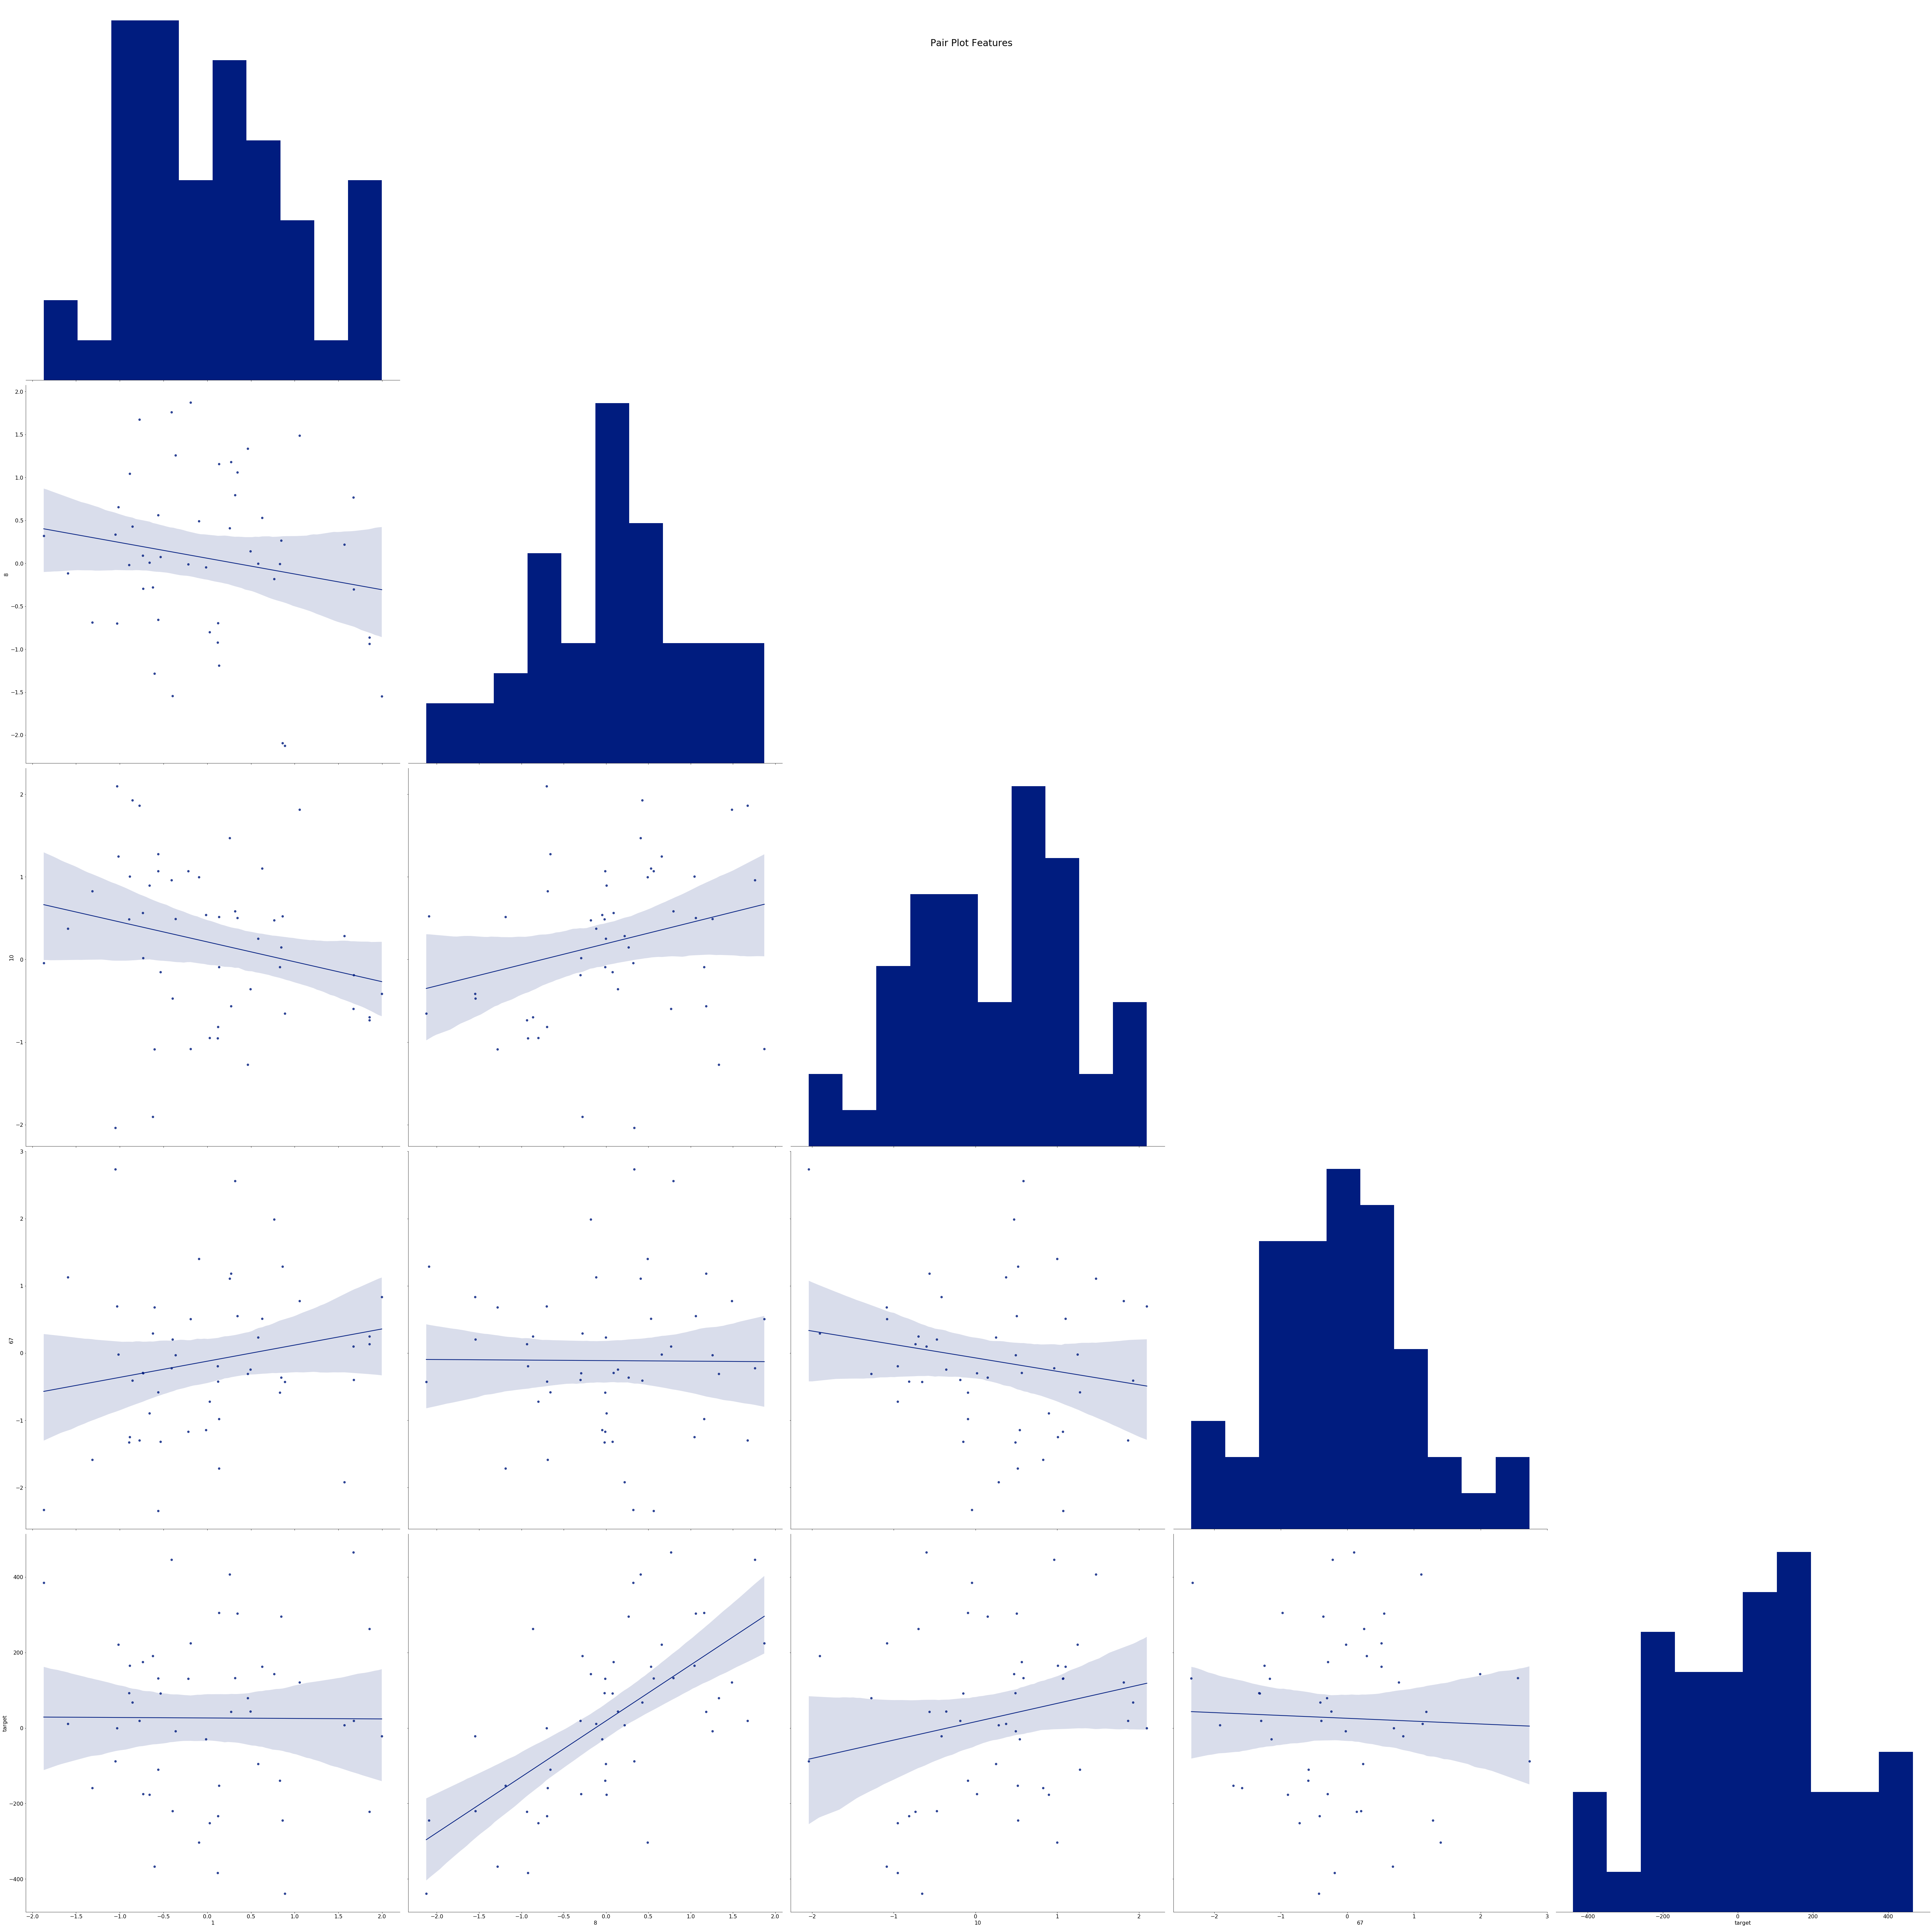

In [140]:
input_features = list(raw_input_df.columns) 
column_to_visualize.append(TARGET_COLUMN)
if DATA_VISUALIZATION_STEP:
    plt.figure(figsize=(20,15))
    sampled = raw_input_df[column_to_visualize].sample(frac=0.5)
    sampled.columns = sampled.columns.astype(str)
    sns.pairplot(sampled, kind="reg", corner=True, diag_kind="auto", height=16)
    plt.suptitle('Pair Plot Features', size = 28);

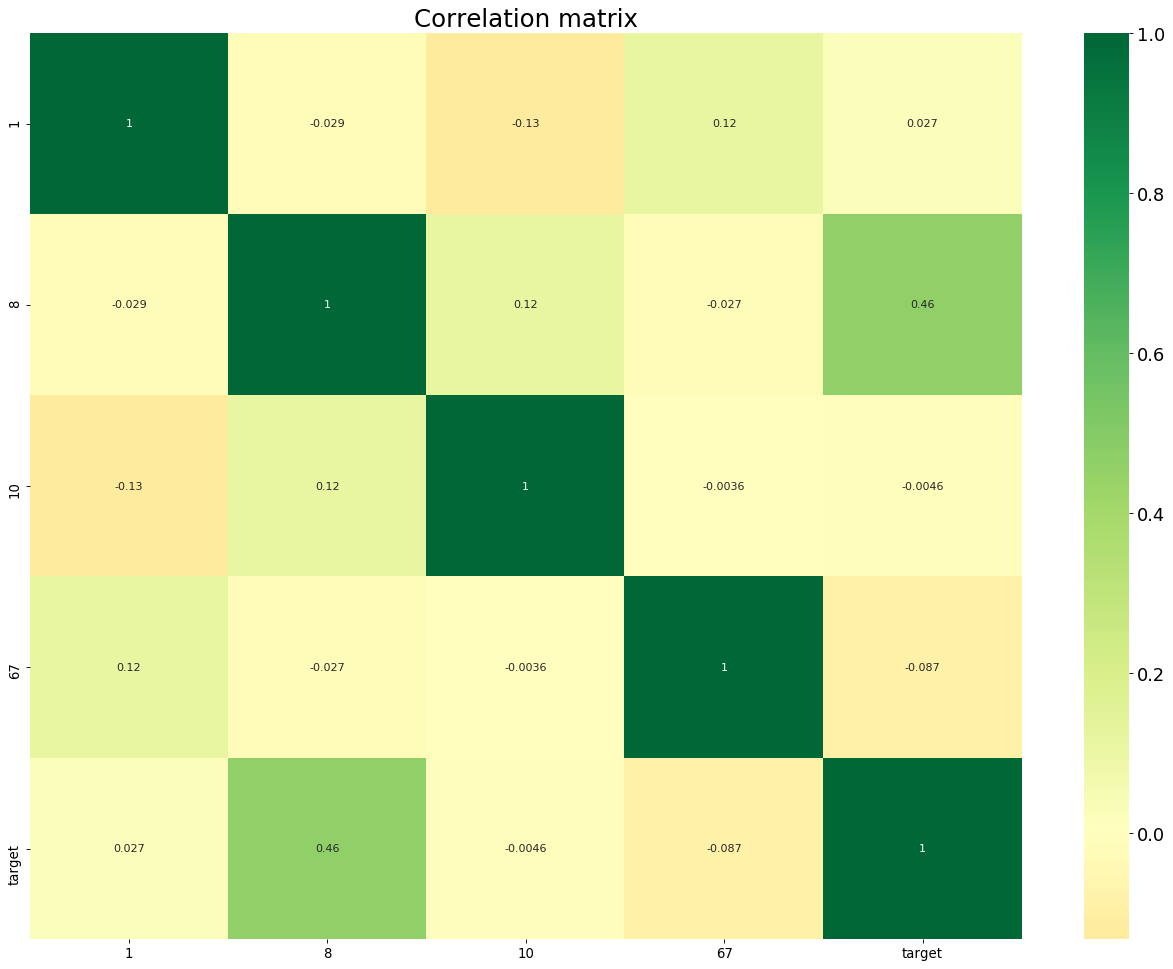

In [141]:
if DATA_VISUALIZATION_STEP:
    plt.figure(figsize=(20,15), dpi= 80)
    sns.heatmap(raw_input_df[column_to_visualize].corr(), xticklabels=raw_input_df[column_to_visualize].corr().columns, yticklabels=raw_input_df[column_to_visualize].corr().columns, cmap='RdYlGn', center=0, annot=True)

    # Decorations
    plt.title('Correlation matrix', fontsize=22)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

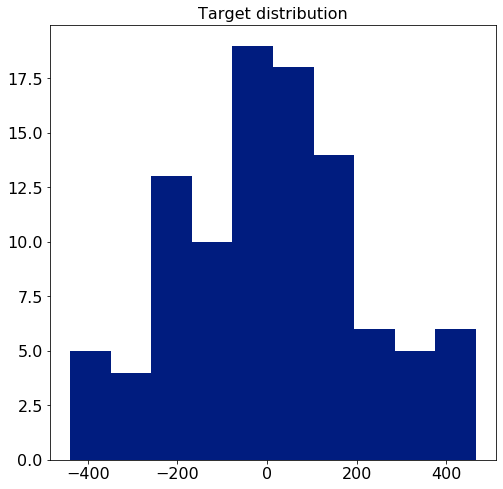

In [142]:
if DATA_VISUALIZATION_STEP:
    raw_input_df[TARGET_COLUMN].plot(kind='hist', subplots=True, figsize=(8, 8))
    plt.title("Target distribution")
    plt.ylabel("")
    plt.show()

### 4-Feature Selection

In [145]:
try:
    input_features.remove(TARGET_COLUMN)
except ValueError:
    pass
new_features = input_features
reduced = False
if NUM_FEATURES and NUM_FEATURES <= len(input_features):
    #feature_names = list(raw_input_df.columns.values)
    reduced = True
    # Create and fit selector
    select_k_best_classifier = SelectKBest(k=NUM_FEATURES, score_func=f_regression)
    fit_transofrmed_features = select_k_best_classifier.fit_transform(raw_input_df[input_features], raw_input_df[TARGET_COLUMN])
    
    mask = select_k_best_classifier.get_support() #list of booleans
    new_features = [] # The list of your K best features

    for bool, feature in zip(mask, input_features):
        if bool:
            new_features.append(feature)
            
    print("Selected features are: %s" % new_features)
    input_df_reduced = pd.DataFrame(fit_transofrmed_features, columns=new_features)
    input_df_reduced[TARGET_COLUMN] = raw_input_df[TARGET_COLUMN].to_numpy()
    display(input_df_reduced.head())
    display(input_df_reduced.describe())
    display(input_df_reduced.info())
else:
    input_df_reduced = raw_input_df

Selected features are: ['8', '39', '64', '66', '93']


,8,39,64,66,93,target
0,0.007306,0.027749,-0.034629,-1.622461,-0.413506,-176.988744
1,-0.045329,0.983992,0.179299,-1.098421,0.370093,-29.355242
2,-1.816374,-0.614829,0.926868,0.180962,0.175311,57.232408
3,-2.124293,-0.019159,-1.702522,-0.628249,-1.791617,-439.160165
4,-0.156879,-1.494005,-0.865097,-0.407419,1.688561,-199.964258


,8,39,64,66,93,target
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.016984,-0.041229,-0.038454,0.000643,0.030783,13.954425
std,1.001905,0.918305,0.913047,0.964019,1.031902,205.923233
min,-2.124293,-2.348789,-2.063505,-2.345553,-2.637198,-439.160165
25%,-0.725753,-0.705598,-0.762043,-0.550251,-0.560566,-136.617484
50%,0.047044,0.046544,-0.055621,0.063129,0.072080,9.884612
75%,0.666876,0.613513,0.612263,0.700525,0.704902,143.629661
max,2.427873,2.130417,2.544103,2.368050,2.374560,465.935249


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   8       100 non-null    float64
 1   39      100 non-null    float64
 2   64      100 non-null    float64
 3   66      100 non-null    float64
 4   93      100 non-null    float64
 5   target  100 non-null    float64
dtypes: float64(6)
memory usage: 4.8 KB


None

### 5-ML model selection

In [146]:
names = [classifier.__class__.__name__ for classifier in regressors]

# preprocess dataset, split into training and test part
X = input_df_reduced.loc[:, input_df_reduced.columns != TARGET_COLUMN]
y = input_df_reduced[TARGET_COLUMN]
X = StandardScaler().fit_transform(X) #ATTENTION: for each prediction we need to fit_transform first
X_train, X_validation, y_train, y_validation = \
    train_test_split(X, y, test_size=.3, random_state=42)
X_validation, X_test, y_validation, y_test = \
    train_test_split(X_validation, y_validation, test_size=.2, random_state=42)

#HERE MACROAVG_F1 IS USED, CHANGE IT IF YOU NEED
indexBestClassifier = 0
maxScore = 0
actualIndex = 0

# iterate over regressors
for name, clf in zip(names, regressors):
    print("#"*10)
    print("Trying with classifier: {}".format(clf))
    clf.fit(X_train, y_train)
    score = clf.score(X_validation, y_validation)
    
    if custom_loss == None:
        score_to_use = score
    else:
        predicted = clf.predict(X_validation)
        score_to_use = custom_loss(y_validation, predicted)
        
    if score_to_use > maxScore:
        maxScore = score_to_use
        indexBestClassifier = actualIndex
    actualIndex +=1
    
print("The best classifier is: {} with score {}".format(regressors[indexBestClassifier], maxScore))

##########
Trying with classifier: SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
##########
Trying with classifier: Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
##########
Trying with classifier: Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
##########
Trying with classifier: BaggingRegressor(base_estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                    epsilon=0.1, gam

### 6-ML model tuning - to be modified manually

In [147]:
'''
params = {
    'learning_rate' : ['optimal','invscaling'],
    'loss' : ['squared_loss'],
    'penalty' : ['l1','l2','elasticnet']
}
'''
params = {
    'max_features' : [1.0, 0.5],
    'n_estimators' : [10,50,100],
    'n_jobs' : [-1],
    'random_state' : [42]
}

param_to_be_varied_in_validation_curve = 'n_estimators'
param_range_valid_curve = [10,50,100]

clf_best = RandomizedSearchCV(regressors[indexBestClassifier], params, n_iter = 15, scoring=scoring_tuning, random_state=42).fit(X,y)
#clf_best = GridSearchCV(regressors[indexBestClassifier], params, scoring='f1_weighted').fit(X,y)
best_estimator = clf_best.best_estimator_
bestScore = clf_best.best_score_
results = pd.DataFrame(clf_best.cv_results_)
print("Results from hyperParams search: ")
print(json.dumps(results.to_dict(),indent=4))
print("Best classifier found: {} with score {}".format(best_estimator,bestScore))

D:\Anaconda\envs\ztm_ml_env\lib\site-packages\sklearn\model_selection\_search.py:277: UserWarning: The total space of parameters 6 is smaller than n_iter=15. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Results from hyperParams search: 
{
    "mean_fit_time": {
        "0": 0.32539777755737304,
        "1": 0.048598718643188474,
        "2": 0.15639910697937012,
        "3": 0.011398649215698243,
        "4": 0.0421966552734375,
        "5": 0.11319637298583984
    },
    "std_fit_time": {
        "0": 0.6253013013342767,
        "1": 0.006829236566832375,
        "2": 0.028732202286036925,
        "3": 0.0004898066925480643,
        "4": 0.0014692696980662698,
        "5": 0.03545973583901887
    },
    "mean_score_time": {
        "0": 0.008400297164916993,
        "1": 0.018200016021728514,
        "2": 0.042999649047851564,
        "3": 0.006000518798828125,
        "4": 0.016002607345581055,
        "5": 0.03520116806030273
    },
    "std_score_time": {
        "0": 0.0013562077233404562,
        "1": 0.0021353596462107692,
        "2": 0.008741205119516472,
        "3": 0.0006320340997975985,
        "4": 0.0010953224309049354,
        "5": 0.007573715429029868
    },
    "para

### 7-Results visualizations

list_scores:  [3.206018893442597, 0.0708181480648262, 8.652434578270734, 1.917113945420891, 4.028233089518191, 2.054132790980057, 1.4448782465207763, 26.8199876940593, 0.0838073189068473, 0.0020640562329669212, 3.3522481044091528, 0.2787778881814274, 0.04604342396319986, 0.8584856368188531, 1.4314737141957052, 0.062493290239383256, 1.0286313971730434, 0.7174253094449088, 1.4290940486812764, 0.2759780274132829, 1.8880481609190165, 0.003383216166416588, 0.18915778719397652, 1.320041658535375, 0.007831851812323485, 0.008480593818480228, 0.23085832696642725, 0.11587085666795365, 2.047519629919625, 0.21775718058146099, 0.17530805777231281, 1.5712333439128412, 4.001346509206382, 1.0154171943308983, 0.3327915179524301, 0.3927570690956854, 2.2406476643491073, 1.519303954273904, 10.180985086661417, 1.630139259308646, 0.47500936525782217, 9.64529800702327, 3.092863708543525, 2.149095571969064, 0.9041390753640861, 2.9841702704986144, 0.07284613604651391, 1.5682460871802328, 1.5286113689578789, 0.

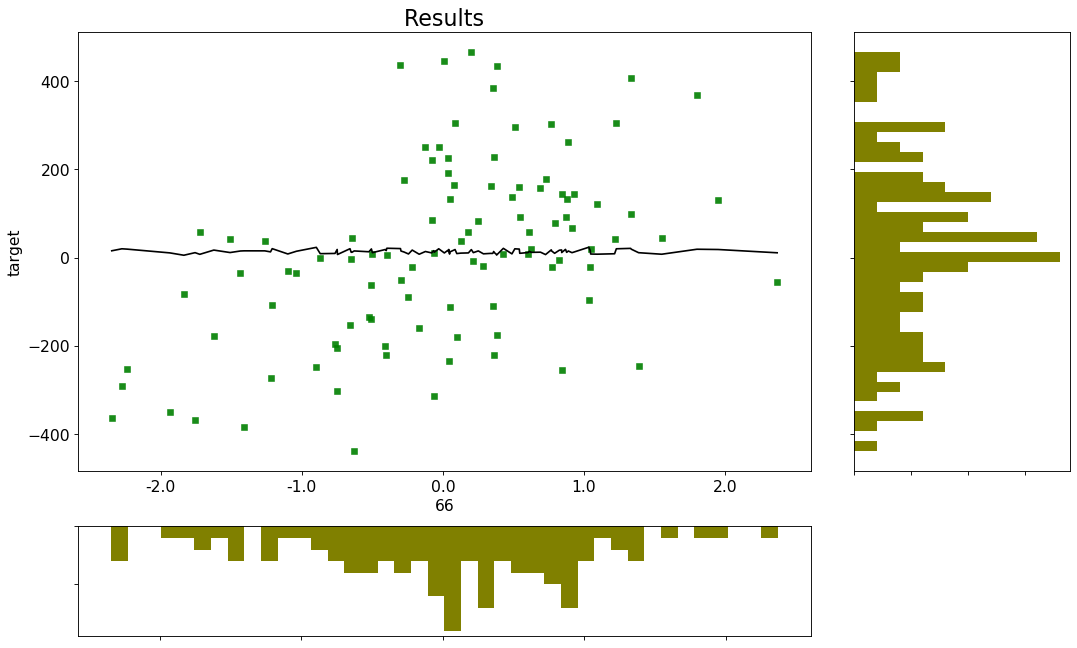

In [179]:
if RESULT_VISUALIZATION_STEP:
    #new_features.append(TARGET_COLUMN)


    if reduced:
        list_scores = list(select_k_best_classifier.scores_)
        print("list_scores: ",list_scores)
        two_best_scores = heapq.nlargest(2, list_scores)
        print("two_best_scores: ",two_best_scores)
        best_feature_one = input_features[list_scores.index(two_best_scores[0])]
        print("best_feature_one: ",best_feature_one)
        best_feature_two = input_features[list_scores.index(two_best_scores[1])]
        print("best_feature_two: ",best_feature_two)
    else:
        best_feature_one = input_features[0]
        best_feature_two = input_features[1]

    input_df_reduced_sorted = raw_input_df.sort_values(by=[best_feature_one])
    X_sorted = input_df_reduced_sorted.loc[:, raw_input_df.columns != TARGET_COLUMN]
    y_sorted = input_df_reduced_sorted[TARGET_COLUMN]
    X_test = X_sorted
    y_test = y_sorted
    y_pred = best_estimator.predict(X_sorted)
    
    # Create Fig and gridspec
    fig = plt.figure(figsize=(16, 10), dpi= 80)
    grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

    # Define the axes
    ax_main = fig.add_subplot(grid[:-1, :-1])
    ax_right = fig.add_subplot(grid[:-1, -1], xticklabels=[], yticklabels=[])
    ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])

    X_test_df = pd.DataFrame(X_test,columns=new_features)
    
    # plot on main ax
    ax_main.scatter(X_test_df[best_feature_one], y_test,color='g',label='correct',marker="s", alpha=.9, cmap="tab10", linewidths=.5)
    ax_main.plot(X_test_df[best_feature_one], y_pred,color='k')
    

    # histogram on the right
    ax_bottom.hist(X_test_df[best_feature_one], 40, histtype='stepfilled', orientation='vertical', color='olive')
    ax_bottom.invert_yaxis()

    # histogram in the bottom
    ax_right.hist(y_test, 40, histtype='stepfilled', orientation='horizontal', color='olive')

    # Decorations
    ax_main.set(title='Results', xlabel=best_feature_one, ylabel=TARGET_COLUMN)
    ax_main.title.set_fontsize(20)
    for item in ([ax_main.xaxis.label, ax_main.yaxis.label] + ax_main.get_xticklabels() + ax_main.get_yticklabels()):
        item.set_fontsize(14)

    xlabels = ax_main.get_xticks().tolist()
    ax_main.set_xticklabels(xlabels)
    plt.show()

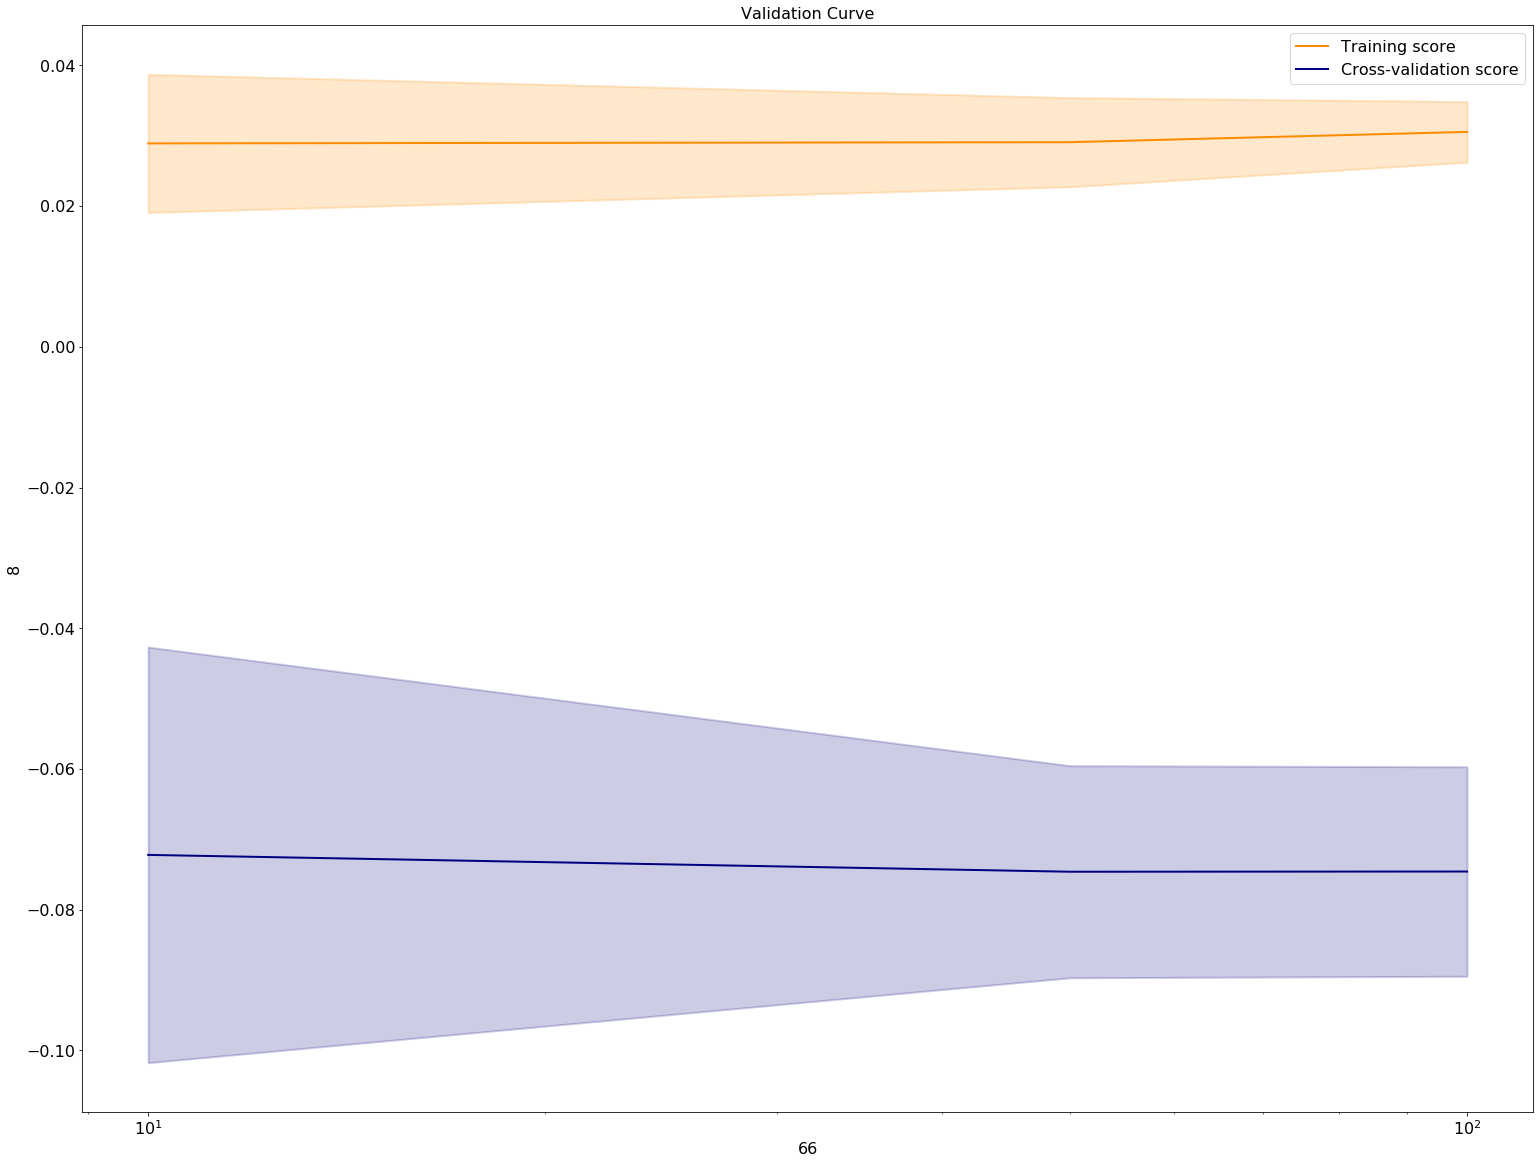

In [182]:
if RESULT_VISUALIZATION_STEP:
    indices = np.arange(y.shape[0])
    np.random.shuffle(indices)
    X_shuffled, y_shuffled = X[indices], y[indices]

    train_scores, valid_scores = validation_curve(best_estimator, X_shuffled, y_shuffled,
                                                  param_to_be_varied_in_validation_curve,
                                                  param_range_valid_curve,
                                                  cv=5)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(valid_scores, axis=1)
    test_scores_std = np.std(valid_scores, axis=1)

    plt.title("Validation Curve")
    plt.xlabel(best_feature_one)
    plt.ylabel(best_feature_two)
    lw = 2
    plt.semilogx(param_range_valid_curve, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range_valid_curve, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range_valid_curve, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range_valid_curve, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

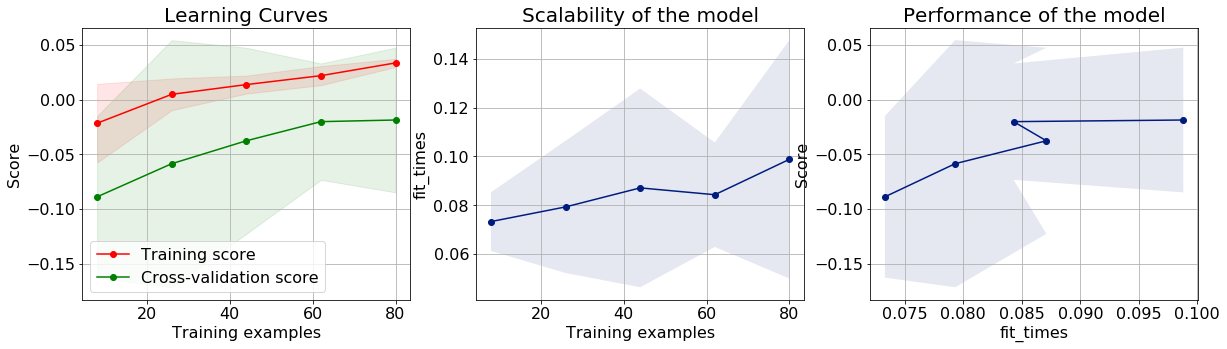

In [183]:
if RESULT_VISUALIZATION_STEP:
    def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                            n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
        """
        Generate 3 plots: the test and training learning curve, the training
        samples vs fit times curve, the fit times vs score curve.

        Parameters
        ----------
        estimator : object type that implements the "fit" and "predict" methods
            An object of that type which is cloned for each validation.

        title : string
            Title for the chart.

        X : array-like, shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples and
            n_features is the number of features.

        y : array-like, shape (n_samples) or (n_samples, n_features), optional
            Target relative to X for classification or regression;
            None for unsupervised learning.

        axes : array of 3 axes, optional (default=None)
            Axes to use for plotting the curves.

        ylim : tuple, shape (ymin, ymax), optional
            Defines minimum and maximum yvalues plotted.

        cv : int, cross-validation generator or an iterable, optional
            Determines the cross-validation splitting strategy.
            Possible inputs for cv are:
              - None, to use the default 5-fold cross-validation,
              - integer, to specify the number of folds.
              - :term:`CV splitter`,
              - An iterable yielding (train, test) splits as arrays of indices.

            For integer/None inputs, if ``y`` is binary or multiclass,
            :class:`StratifiedKFold` used. If the estimator is not a classifier
            or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

            Refer :ref:`User Guide <cross_validation>` for the various
            cross-validators that can be used here.

        n_jobs : int or None, optional (default=None)
            Number of jobs to run in parallel.
            ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
            ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
            for more details.

        train_sizes : array-like, shape (n_ticks,), dtype float or int
            Relative or absolute numbers of training examples that will be used to
            generate the learning curve. If the dtype is float, it is regarded as a
            fraction of the maximum size of the training set (that is determined
            by the selected validation method), i.e. it has to be within (0, 1].
            Otherwise it is interpreted as absolute sizes of the training sets.
            Note that for classification the number of samples usually have to
            be big enough to contain at least one sample from each class.
            (default: np.linspace(0.1, 1.0, 5))
        """
        if axes is None:
            _, axes = plt.subplots(1, 3, figsize=(20, 5))

        axes[0].set_title(title)
        axes[0].title.set_fontsize(20)
        if ylim is not None:
            axes[0].set_ylim(*ylim)
        axes[0].set_xlabel("Training examples")
        axes[0].set_ylabel("Score")

        train_sizes, train_scores, test_scores, fit_times, _ = \
            learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                           train_sizes=train_sizes,
                           return_times=True)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        fit_times_mean = np.mean(fit_times, axis=1)
        fit_times_std = np.std(fit_times, axis=1)

        # Plot learning curve
        axes[0].grid()
        axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1,
                             color="r")
        axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1,
                             color="g")
        axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                     label="Training score")
        axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                     label="Cross-validation score")
        axes[0].legend(loc="best")

        # Plot n_samples vs fit_times
        axes[1].grid()
        axes[1].plot(train_sizes, fit_times_mean, 'o-')
        axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                             fit_times_mean + fit_times_std, alpha=0.1)
        axes[1].set_xlabel("Training examples")
        axes[1].set_ylabel("fit_times")
        axes[1].set_title("Scalability of the model")
        axes[1].title.set_fontsize(20)

        # Plot fit_time vs score
        axes[2].grid()
        axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
        axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1)
        axes[2].set_xlabel("fit_times")
        axes[2].set_ylabel("Score")
        axes[2].set_title("Performance of the model")
        axes[2].title.set_fontsize(20)

        return plt


    title = "Learning Curves"
    # Cross validation with 100 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

    estimator = best_estimator
    plot_learning_curve(estimator, title, X, y,cv=cv, n_jobs=-1)

    plt.show()

### 8-Model export

In [ ]:
if MODEL_EXPORT:
    from joblib import dump, load
    dump(best_estimator, MODEL_EXP_PATH)

### 9-Python and html generation

In [ ]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

In [ ]:
if REPORT_GEN:
    import nbformat
    from nbconvert import PythonExporter
    import os
    import codecs
    from IPython.display import Javascript
    import time
    from nbconvert import HTMLExporter


    def convertNotebook(notebookPath, modulePath):

      with open(notebookPath) as fh:
        nb = nbformat.reads(fh.read(), nbformat.NO_CONVERT)

      exporter = PythonExporter()
      source, meta = exporter.from_notebook_node(nb)
      with open(modulePath, 'w+') as fh:
        fh.writelines(source)


    def save_notebook():
        display(
            Javascript("IPython.notebook.save_notebook()"),
            include=['application/javascript']
        )

    def output_HTML(read_file, output_file):
        exporter = HTMLExporter()
        # read_file is '.ipynb', output_file is '.html'
        output_notebook = nbformat.read(read_file, as_version=4)
        output, resources = exporter.from_notebook_node(output_notebook)
        codecs.open(output_file, 'w', encoding='utf-8').write(output)

    nb_full_path = os.path.join(os.getcwd(), theNotebook)
    convertNotebook(nb_full_path+".ipynb", OUTPUT_SCRIPT_NAME)

    save_notebook()
    time.sleep(3)
    current_file = theNotebook+".ipynb"
    output_HTML(current_file, OUTPUT_HTML_NAME)